# Assignment 3
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se
***

## Part 3: Implementing your stance classification system
***

In [152]:
import pandas as pd
import re
from collections import Counter
import spacy
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.stats import loguniform

# Specify dataset column names
column_names = ['sentiment', 'comments']

# Load dataset
sample_df = pd.read_csv('data/a3_first_sample.tsv', sep='\t', header=None, names=column_names)
training_df = pd.read_csv('data/a3_train_final.tsv', sep='\t', header=None, names=column_names) 
test_df = pd.read_csv('data/a3_test.tsv', sep='\t', header=None, names=column_names)

# Display first 10 rows of the datasets
training_df.head(10)

,sentiment,comments
0,1/1,I'll only consume if I know what's inside it....
1,0/-1,It is easier to fool a million people than it...
2,0/0,NATURAL IMMUNITY protected us since evolutio...
3,0/-1,NATURAL IMMUNITY protected us since evolutio...
4,0/0,"Proud to have resisted. Proud of my husband, ..."
5,1/1/1/-1,The bigest sideffect of vaccines is fewer dea...
6,1/-1,Unvaccinated people are more likely to become...
7,1/1,Vaccine takes more than a year to develop. T...
8,0/0,YES IM A TRUCKER FROM USA AND I WONT GET VACC...
9,0/0,"covid vaccines are safe , Goes to show , if ..."


In [153]:
# Information about the dataset
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  975 non-null    int64 
 1   comments   975 non-null    object
dtypes: int64(1), object(1)
memory usage: 15.4+ KB


In [154]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50068 entries, 0 to 50067
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50068 non-null  object
 1   comments   50068 non-null  object
dtypes: object(2)
memory usage: 782.4+ KB


In [155]:
# Determine the amount of missing values in the datasets
sample_df.isnull().sum()

sentiment    0
comments     0
dtype: int64

In [156]:
training_df.isnull().sum()

sentiment    0
comments     0
dtype: int64

In [157]:
# Count the frequency of each unique sentiment combination
sentiment_counts = training_df['sentiment'].value_counts()

# Calculate the consensus metrics
total_rows = len(training_df)
full_consensus_count = sentiment_counts[sentiment_counts.index.map(lambda x: len(set(x.split('/'))) == 1)].sum()
partial_consensus_count = total_rows - full_consensus_count

# Calculate the percentages
full_consensus_percentage = (full_consensus_count / total_rows) * 100
partial_consensus_percentage = (partial_consensus_count / total_rows) * 100

# Print the consensus analysis
print(f"Total number of rows: {total_rows}")
print(f"Rows with full consensus: {full_consensus_count} ({full_consensus_percentage:.2f}%)")
print(f"Rows with partial or no consensus: {partial_consensus_count} ({partial_consensus_percentage:.2f}%)")

# Display the frequency of each unique sentiment combination
print("\nFrequency of each unique sentiment combination:")
print(sentiment_counts)

Total number of rows: 50068
Rows with full consensus: 42247 (84.38%)
Rows with partial or no consensus: 7821 (15.62%)

Frequency of each unique sentiment combination:
1/1                            19248
0/0                            18221
0/-1                            2434
1/-1                            2082
1/0                             1467
                               ...  
0/1/0/0/0                          1
0/0/1/-1                           1
1/1/1/1/1/1/1/1/1/0/1/1/1/1        1
0/1/0/1/1/0/0/1                    1
1/0/-1/-1                          1
Name: sentiment, Length: 190, dtype: int64


Sentiment Combination Approach

In [158]:
def extract_majority_label(labels):
    """
    Extracts the majority label from a string of annotations separated by '/'.
    Returns None if there's no clear majority.
    """
    label_counts = Counter(labels.split('/'))
    most_common = label_counts.most_common()

    # Check if there's a clear majority or if it's a tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return None  # It's a tie or no clear majority
    return most_common[0][0]  # Return the label with the majority

In [159]:
# Apply the function to extract the majority label or filter out non-consensus comments
training_df['major_sentiment'] = training_df['sentiment'].apply(extract_majority_label)

# Filter out rows where MajorityLabel is no consensus
consensus_data = training_df.dropna(subset=['major_sentiment'])
consensus_data = consensus_data.drop(columns=['sentiment']).rename(columns={'major_sentiment': 'sentiment'})

# Display the first few rows of the consensus dataframe and the size of the filtered data
print(consensus_data)
print(f"\nSize of the filtered data: {consensus_data.shape}")

                                                comments sentiment
0       I'll only consume if I know what's inside it....         1
2       NATURAL IMMUNITY  protected us since evolutio...         0
4       Proud to have resisted. Proud of my husband, ...         0
5       The bigest sideffect of vaccines is fewer dea...         1
7       Vaccine takes more than a year to develop.  T...         1
...                                                  ...       ...
50063  🤣 keep your 💩 I already know 3 people who have...         0
50064  🤣🤣🤣 "JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...         0
50065  🤣🤣🤣 I took the Vaccine because of work. If I d...         0
50066  🤨there's people already having severe side eff...         0
50067  🥦I ❤my covid vaccines and I'm so excited for m...         1

[42840 rows x 2 columns]

Size of the filtered data: (42840, 2)


Text Preprocessing

In [160]:
def simple_preprocess(sentence):
    """Perform simple preprocessing of text without removing special characters that might affect sentiment."""
    sentence = str(sentence)
    sentence = re.sub(r'http\S+', '', sentence)  # Remove URLs
    sentence = re.sub(r'www\S+', '', sentence)   # Remove URLs
    sentence = re.sub(r'\n', ' ', sentence)      # Replace newline characters with space
    sentence = re.sub(r'\s\s+', ' ', sentence)   # Replace multiple spaces with a single space
    return sentence.strip()

In [161]:
def get_sentiment(sentence):
    """Extract sentiment from text based on polarity value."""
    score = TextBlob(sentence).sentiment.polarity
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

def get_subjectivity(sentence):
    """Calculate subjectivity of text."""
    return TextBlob(sentence).sentiment.subjectivity

In [162]:
def further_preprocess(sentence):
    """Apply further cleaning and normalization suitable after sentiment analysis."""
    sentence = sentence.lower()
    sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", sentence)
    sentence = re.sub(r'[0-9]+', '', sentence)
    sentence = re.sub(r'\s\s+', ' ', sentence)
    return sentence.strip()

In [163]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Add additional stop words to spaCy's stop words list
additional_stop_words = [
    'vaccine', 'vaccination', 'vaccinate', 'vaccinated', 'use', 'people', 'person', 'like', 'think', 'know', 'case', 'want', 'mean', 'find', 'read', 'point'
]

for word in additional_stop_words:
    nlp.vocab[word].is_stop = True

# Lemmatization function
def lemmatize(sentence):
    doc = nlp(sentence, disable=['ner', 'parser'])
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(lemmas)

In [164]:
# Filter out the instances with a sentiment value of -1 given the small sample size of 22 instances
consensus_data = consensus_data[consensus_data['sentiment'] != '-1']

# Basic Preprocessing
consensus_data['basic_cleaned'] = consensus_data['comments'].apply(simple_preprocess)

# TextBlob Sentiment and Subjectivity Analysis
consensus_data['calculated_sentiment'] = consensus_data['basic_cleaned'].apply(get_sentiment)
consensus_data['calculated_subjectivity'] = consensus_data['basic_cleaned'].apply(get_subjectivity)

# Further Cleaning and Normalization
consensus_data['further_cleaned'] = consensus_data['basic_cleaned'].apply(further_preprocess)

# Lemmatization and Stop Word Removal
consensus_data['final_text'] = consensus_data['further_cleaned'].apply(lemmatize)

# Display the top 10 instances
consensus_data[['comments', 'sentiment', 'calculated_sentiment', 'calculated_subjectivity', 'final_text']].head(10)

,comments,sentiment,calculated_sentiment,calculated_subjectivity,final_text
0,I'll only consume if I know what's inside it....,1,Neutral,1.000000,consume inside drink monster taurine
2,NATURAL IMMUNITY protected us since evolutio...,0,Positive,0.400000,natural immunity protect evolution exist anymore
4,"Proud to have resisted. Proud of my husband, ...",0,Positive,0.708333,proud resist proud husband mother family prote...
5,The bigest sideffect of vaccines is fewer dea...,1,Negative,0.400000,bigest sideffect vaccine few dead child savage
7,Vaccine takes more than a year to develop. T...,1,Positive,0.500000,take year develop mistake make anymore vaccine...
8,YES IM A TRUCKER FROM USA AND I WONT GET VACC...,0,Neutral,0.000000,yes m trucker usa will not retweet follow patr...
9,"covid vaccines are safe , Goes to show , if ...",0,Positive,0.500000,covid vaccine safe go money pay
11,out of anger People say stupid things man is ...,1,Negative,0.335714,anger stupid thing man spot get m year old old...
13,... it's been politicized in a way that has co...,0,Neutral,0.000000,politicize way cost life investigate hold acco...
15,... vaccines are safe and effective. Why? Beca...,0,Positive,0.650000,vaccine safe effective say


Sentiment Analysis

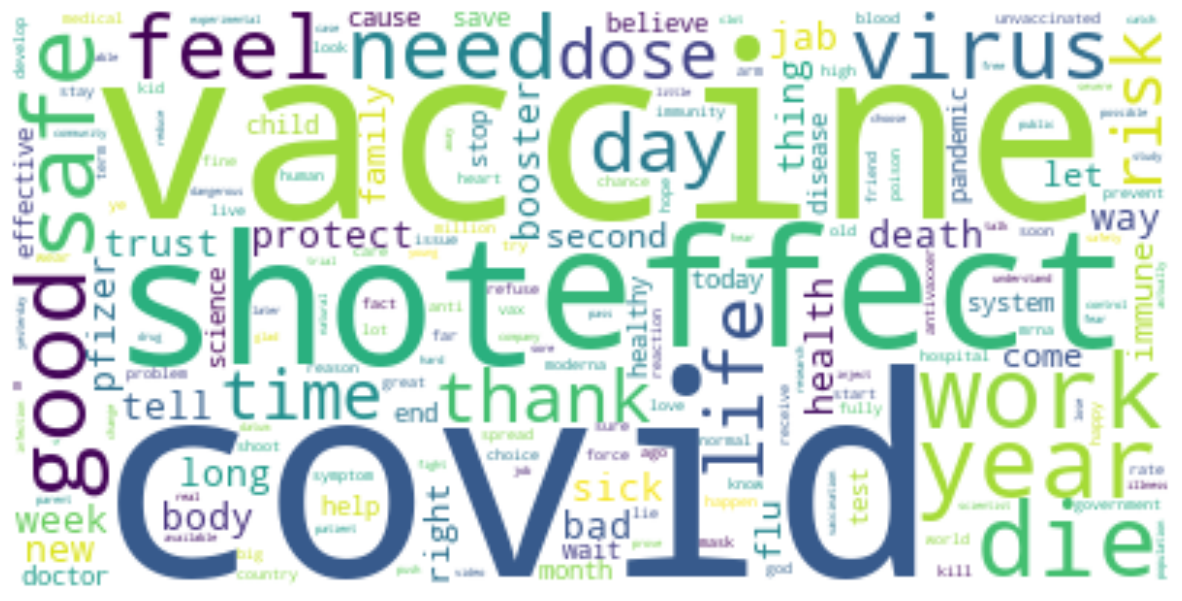

In [165]:
# Now, create a combined set of stop words for use in the WordCloud
stop_words = set(nlp.Defaults.stop_words)

# Concatenate all the comments into a single string
comments_words = ' '.join(consensus_data['final_text'].astype(str))

# Create and generate a word cloud image using the combined set of stop words
my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200, collocations=False).generate(comments_words)

# Display the generated word cloud image
plt.figure(figsize=(15, 10))
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

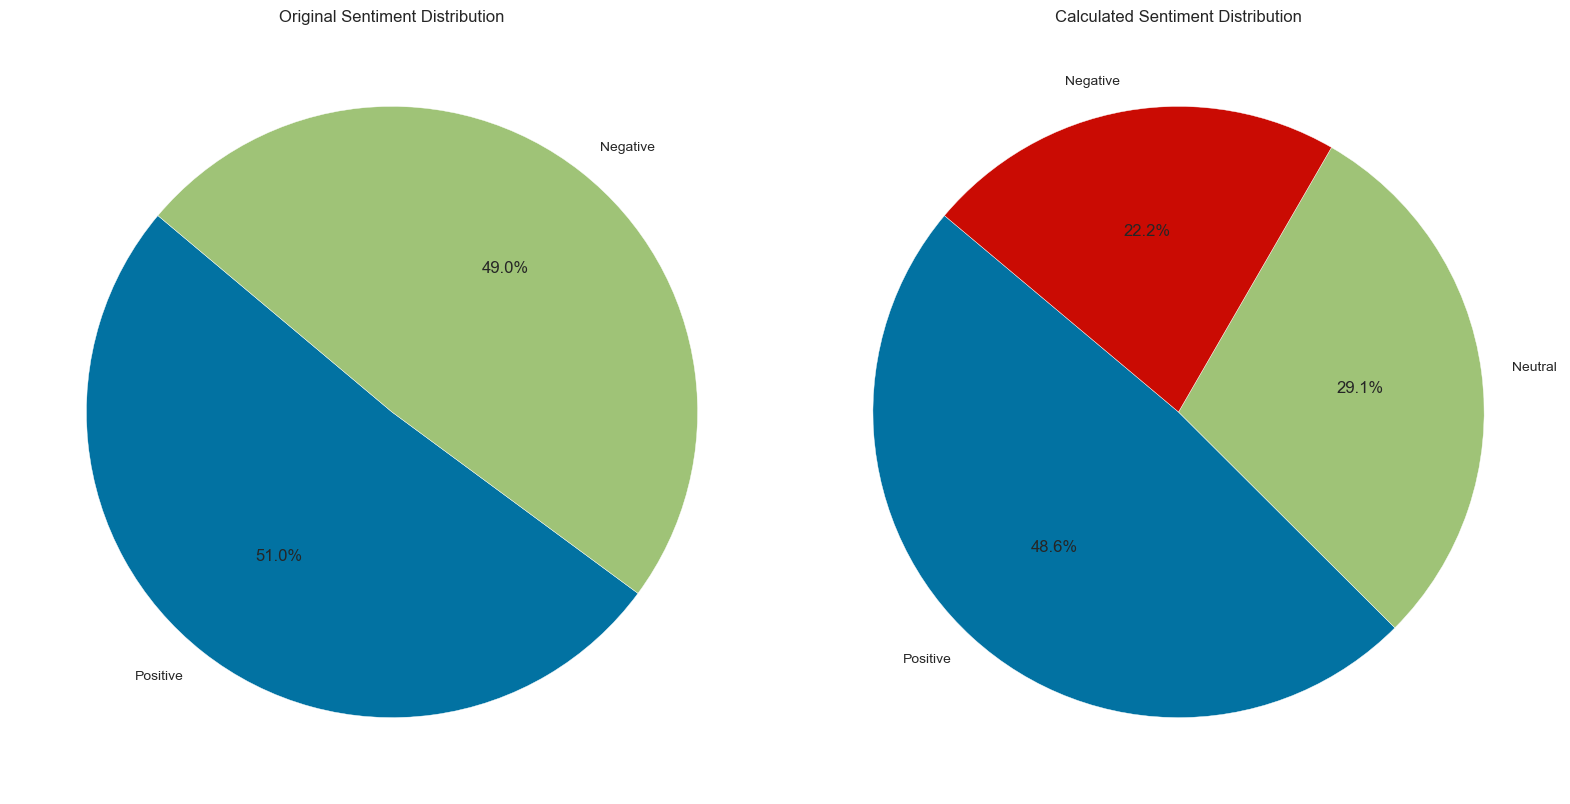

In [166]:
# Map the numerical sentiment values to descriptive categories
sentiment_mapping = {'1': 'Positive', '0': 'Negative'}
consensus_data['sentiment_label'] = consensus_data['sentiment'].map(sentiment_mapping)

# Create pie charts for both original and calculated sentiment distributions
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Original Sentiment Distribution
original_sentiment_counts = consensus_data['sentiment_label'].value_counts(normalize=True)
original_labels = original_sentiment_counts.index

axs[0].pie(original_sentiment_counts, labels=original_labels, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Original Sentiment Distribution')

# Calculated Sentiment Distribution
calculated_sentiment_counts = consensus_data['calculated_sentiment'].value_counts(normalize=True)
calculated_labels = calculated_sentiment_counts.index

axs[1].pie(calculated_sentiment_counts, labels=calculated_labels, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Calculated Sentiment Distribution')

plt.tight_layout()
plt.show()

Data Preparation

In [167]:
X = consensus_data['final_text']  # final_text is the preprocessed text
y = consensus_data['sentiment']    # sentiment is the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Baseline Models

In [168]:
# Function to create, fit, and evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred, zero_division=0))
    return model

In [169]:
# Logistic Regression Pipeline
print("Logistic Regression Results:")
lr_pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LogisticRegression(C=1, random_state=0))
evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test)

# Naive Bayes Pipeline
print("\nNaive Bayes Results:")
nb_pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())
evaluate_model(nb_pipeline, X_train, X_test, y_train, y_test)

# SVC Pipeline
print("\nLinearSVC Results:")
svc_pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LinearSVC(random_state=0))
evaluate_model(svc_pipeline, X_train, X_test, y_train, y_test)

# Random Forest Pipeline
print("\nRandom Forest Results:")
rf_pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), RandomForestClassifier(random_state=0))
evaluate_model(rf_pipeline, X_train, X_test, y_train, y_test)

Logistic Regression Results:
Accuracy: 0.8061653432975245
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6231
           1       0.81      0.82      0.81      6615

    accuracy                           0.81     12846
   macro avg       0.81      0.81      0.81     12846
weighted avg       0.81      0.81      0.81     12846


Naive Bayes Results:
Accuracy: 0.8107582126732057
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      6231
           1       0.79      0.86      0.82      6615

    accuracy                           0.81     12846
   macro avg       0.81      0.81      0.81     12846
weighted avg       0.81      0.81      0.81     12846


LinearSVC Results:
Accuracy: 0.8153510820488868
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      6231
           1       0.82      0.83      0.82      6615

    accuracy            

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

Hyperparameter Tuning

In [170]:
# Logistic Regression hyperparameter distribution
lr_param_distributions = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': uniform(0.7, 0.3),
    'tfidfvectorizer__min_df': uniform(0.01, 0.05),
    'logisticregression__C': loguniform(1e-4, 1e2),  # Log-uniform distribution
    'logisticregression__penalty': ['l1', 'l2'],  # Regularization penalty
}

# Create a Logistic Regression pipeline
lr_pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(solver='saga', random_state=0))

# Set up RandomizedSearchCV for Logistic Regression
lr_random_search = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=lr_param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
lr_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfidfvectorizer',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                             

In [171]:
nb_param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': [0.5, 0.7, 0.9],
    'tfidfvectorizer__min_df': [1, 2, 5],
    'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0],
}

# Set up RandomizedSearchCV for Multinomial Naive Bayes
nb_random_search = RandomizedSearchCV(
    nb_pipeline,
    param_distributions=nb_param_grid,
    n_iter=10,  # Adjust based on computational resource and time
    cv=5,  # Using 5-fold cross-validation
    verbose=2,
    random_state=0,
    n_jobs=-1  # Use all available cores
)

# Perform the search
nb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfidfvectorizer',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                             

In [172]:
# LinearSVC hyperparameter distribution
svc_param_distributions = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': uniform(0.7, 0.3),
    'tfidfvectorizer__min_df': uniform(0.01, 0.05),
    'linearsvc__C': uniform(0.1, 10),
}

# Create a LinearSVC pipeline
svc_pipeline = make_pipeline(TfidfVectorizer(), LinearSVC(random_state=0))

# Set up RandomizedSearchCV for LinearSVC
svc_random_search = RandomizedSearchCV(
    svc_pipeline,
    param_distributions=svc_param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
svc_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfidfvectorizer',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                             

In [173]:
# Random Forest hyperparameter distribution
rf_param_distributions = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': uniform(0.7, 0.3),
    'tfidfvectorizer__min_df': uniform(0.01, 0.05),
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [10, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
}

# Create a Random Forest pipeline
rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=0))

# Set up RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
rf_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfidfvectorizer',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                             

In [175]:
# Evaluate the best model from RandomizedSearchCV
def evaluate_best_model(random_search, X_test, y_test):
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Best parameters: {random_search.best_params_}")

# Evaluate Logistic Regression best model
print("Best Logistic Regression Model:")
evaluate_best_model(lr_random_search, X_test, y_test)

# Evaluate LinearSVC best model
print("\nBest LinearSVC Model:")
evaluate_best_model(svc_random_search, X_test, y_test)

# Evaluate Random Forest best model
print("\nBest Random Forest Model:")
evaluate_best_model(rf_random_search, X_test, y_test)

# Evaluate Multinomial Naive Bayes model
print("\nBest  Naive Bayes Model:")
evaluate_best_model(nb_random_search, X_test, y_test)

Best Logistic Regression Model:
Test accuracy: 0.6553012610929472
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      6231
           1       0.69      0.61      0.64      6615

    accuracy                           0.66     12846
   macro avg       0.66      0.66      0.66     12846
weighted avg       0.66      0.66      0.65     12846

Best parameters: {'logisticregression__C': 0.13523525694052882, 'logisticregression__penalty': 'l1', 'tfidfvectorizer__max_df': 0.8420801258039972, 'tfidfvectorizer__min_df': 0.019316617166338, 'tfidfvectorizer__ngram_range': (1, 1)}

Best LinearSVC Model:
Test accuracy: 0.7078468005604858
              precision    recall  f1-score   support

           0       0.69      0.72      0.71      6231
           1       0.73      0.69      0.71      6615

    accuracy                           0.71     12846
   macro avg       0.71      0.71      0.71     12846
weighted avg       0.71      0.71      0.71 

Model Evaluation

References
